# **Stronger Together: Modeling species distribution under limited occurrence data with Deep Learning and Synthetic Oversample**
### ***Mariana Santos Rodrigues**, Talita Ferreira Amado, Anderson Eduardo Aires, Sidney Feitosa Gouveia, Pablo Riul, Pablo Ariel Martinez*

---

> Species Distribution Models face a major challenge in dealing with rare or under-sampled species, due to statistical biases resulting from the lack of training data. To address this issue, in this study we propose the use of the MLSMOTE technique (Multi-Label Synthetic Minority Over-sampling Technique) to generate synthetic samples of minority classes within the most imbalanced labels of the dataset.

> To build the dataset, we used presence records of 48 tetrapod species endemic to the Caatinga Domain, which also served as the study area for our analyses.




# Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import random
import os
import google.colab
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers


# Import the dataset




In [ ]:
### Dataset containing the presence–absence matrix along with the respective climatic variables

google.colab.drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/dataset/matriz_sp_varclim.csv', sep=';', encoding='latin-1')
df.head()

Mounted at /content/drive


,x,y,Acratosaura.mentalis,Adelophryne.baturitensis,Adelophryne.maranguapensis,Ameivula.nigrigula,Anodorhynchus.leari,Anopetia.gounellei,Anotosaura.vanzolinia,Antilophia.bokermanni,...,wc2.1_30s_bio_10,wc2.1_30s_bio_11,wc2.1_30s_bio_12,wc2.1_30s_bio_13,wc2.1_30s_bio_14,wc2.1_30s_bio_15,wc2.1_30s_bio_16,wc2.1_30s_bio_17,wc2.1_30s_bio_18,wc2.1_30s_bio_19
0,-47.4465,-7.2695,0,0,0,0,0,0,0,0,...,26.916666,25.133333,1660,279,9,74.779877,795,41,194,795
1,-46.7495,-8.4995,0,0,0,0,0,0,0,0,...,25.333334,23.533333,1325,213,4,76.418686,602,24,175,602
2,-46.0935,-15.9205,0,0,0,0,0,0,0,0,...,24.950001,21.333334,1260,255,6,88.611702,690,20,357,30
3,-46.0525,-14.8955,0,0,0,0,0,0,0,0,...,23.600000,20.833334,1549,324,2,91.086655,847,13,411,32
4,-45.6835,-12.0665,0,0,0,0,0,0,0,0,...,24.716667,22.600000,1261,256,3,90.321068,684,9,310,30


In [ ]:
### Dataframe preprocessing
  ## in our dataframe, each row represents a grid cell (spatial resolution of 2.5 arcmin), followed respectively by the presence–absence record of 48 species and the values of 19 bioclimatic variables from the centroid

  ## extracting the centroid coordinates of the grid cells and checking the dataframe format
df.drop([ 'x', 'y'], axis=1, inplace=True)
df.shape

(1751, 67)

In [ ]:
### Splitting the training and test sets

  ## the test set corresponds to 20% of the data
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
### Splitting our predictor (bioclimatic variables) and response (species presence–absence) sets

  ## predictor sets
x_train = train_set.drop(train_set.iloc[:,0:48],axis=1)
x_test = test_set.drop(test_set.iloc[:,0:48],axis=1)

  ## response sets
y_train =   train_set.drop(["wc2.1_30s_bio_1","wc2.1_30s_bio_2","wc2.1_30s_bio_3","wc2.1_30s_bio_4","wc2.1_30s_bio_5","wc2.1_30s_bio_6","wc2.1_30s_bio_7","wc2.1_30s_bio_8","wc2.1_30s_bio_9","wc2.1_30s_bio_10","wc2.1_30s_bio_11","wc2.1_30s_bio_12","wc2.1_30s_bio_13","wc2.1_30s_bio_14","wc2.1_30s_bio_15","wc2.1_30s_bio_16","wc2.1_30s_bio_17","wc2.1_30s_bio_18","wc2.1_30s_bio_19"],axis=1)
y_test =   test_set.drop(["wc2.1_30s_bio_1","wc2.1_30s_bio_2","wc2.1_30s_bio_3","wc2.1_30s_bio_4","wc2.1_30s_bio_5","wc2.1_30s_bio_6","wc2.1_30s_bio_7","wc2.1_30s_bio_8","wc2.1_30s_bio_9","wc2.1_30s_bio_10","wc2.1_30s_bio_11","wc2.1_30s_bio_12","wc2.1_30s_bio_13","wc2.1_30s_bio_14","wc2.1_30s_bio_15","wc2.1_30s_bio_16","wc2.1_30s_bio_17","wc2.1_30s_bio_18","wc2.1_30s_bio_19"],axis=1)

In [ ]:
x_train.head() #just to check

,wc2.1_30s_bio_1,wc2.1_30s_bio_2,wc2.1_30s_bio_3,wc2.1_30s_bio_4,wc2.1_30s_bio_5,wc2.1_30s_bio_6,wc2.1_30s_bio_7,wc2.1_30s_bio_8,wc2.1_30s_bio_9,wc2.1_30s_bio_10,wc2.1_30s_bio_11,wc2.1_30s_bio_12,wc2.1_30s_bio_13,wc2.1_30s_bio_14,wc2.1_30s_bio_15,wc2.1_30s_bio_16,wc2.1_30s_bio_17,wc2.1_30s_bio_18,wc2.1_30s_bio_19
199,26.908333,11.300000,71.518990,109.312607,35.299999,19.500000,15.799999,26.049999,27.016666,28.483334,25.966667,1562,364,10,96.497757,930,48,78,231
1374,23.483334,8.816667,67.302795,162.471451,30.100000,17.000000,13.100000,23.100000,22.250000,25.150000,21.316666,808,100,37,30.514490,280,129,210,216
798,22.791666,9.850000,71.897820,137.705765,29.900000,16.200001,13.699999,23.633333,23.200001,24.150000,20.833334,707,167,7,94.509766,434,29,91,92
1232,20.174999,9.016666,70.442703,144.686188,27.000000,14.200000,12.800000,20.533333,20.350000,21.616667,18.233334,826,139,13,63.651318,358,59,91,257
1573,22.204166,11.658334,79.851601,79.213715,29.799999,15.200000,14.599999,21.650000,22.666666,23.150000,21.333332,1170,294,4,109.208397,760,13,60,715


In [ ]:
y_train.head() #just to check

,Acratosaura.mentalis,Adelophryne.baturitensis,Adelophryne.maranguapensis,Ameivula.nigrigula,Anodorhynchus.leari,Anopetia.gounellei,Anotosaura.vanzolinia,Antilophia.bokermanni,Augastes.lumachella,Callicebus.barbarabrownae,...,Synallaxis.hellmayri,Tropidurus.cocorobensis,Tropidurus.erythrocephalus,Tropidurus.helenae,Tropidurus.jaguaribanus,Tropidurus.pinima,Tropidurus.semitaeniatus,Vanzosaura.multiscutata,Wiedomys.pyrrhorhinos,Xeronycteris.vieirai
199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1573,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
### Creating a copy to preserve the original dataframe
y = y_train.copy()
X = x_train.copy()
print(y.shape, X.shape)

(1400, 48) (1400, 19)


In [ ]:
print(X.head(), y.head()) # just to check

      wc2.1_30s_bio_1  wc2.1_30s_bio_2  wc2.1_30s_bio_3  wc2.1_30s_bio_4  \
199         26.908333        11.300000        71.518990       109.312607   
1374        23.483334         8.816667        67.302795       162.471451   
798         22.791666         9.850000        71.897820       137.705765   
1232        20.174999         9.016666        70.442703       144.686188   
1573        22.204166        11.658334        79.851601        79.213715   

      wc2.1_30s_bio_5  wc2.1_30s_bio_6  wc2.1_30s_bio_7  wc2.1_30s_bio_8  \
199         35.299999        19.500000        15.799999        26.049999   
1374        30.100000        17.000000        13.100000        23.100000   
798         29.900000        16.200001        13.699999        23.633333   
1232        27.000000        14.200000        12.800000        20.533333   
1573        29.799999        15.200000        14.599999        21.650000   

      wc2.1_30s_bio_9  wc2.1_30s_bio_10  wc2.1_30s_bio_11  wc2.1_30s_bio_12  \
199    

# MLSMOTE
Using the Multi-Label Synthetic Minority Over-sampling Technique (MLSMOTE) to tackle imbalanced data.

In [ ]:
### First, it is necessary to identify the most imbalanced labels
  ## (i) To do this, we first calculate the imbalance ratio (irpl) for each label.
  ## (ii) Then, we determine the mean imbalance ratio (mir) across all labels.
  ## (iii) Labels with an irpl above the mir are considered "tail labels," i.e., the labels that need to be counterbalanced

def get_tail_label(train_set):
    columns = train_set.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = train_set[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

In [ ]:
### To visualize the labels identified as the most imbalanced, we can:
tail_labels = get_tail_label(y_train)
print(tail_labels)

['Adelophryne.maranguapensis', 'Ameivula.nigrigula', 'Anotosaura.vanzolinia', 'Colobosauroides.cearensis', 'Copeoglossum.arajara', 'Glaucomastix.cyanura', 'Glaucomastix.venetacauda', 'Leptodactylus.oreomantis', 'Lonchophylla.inexpectata', 'Nothobachia.ablephara', 'Placosoma.limaverdorum', 'Procellosaurinus.erythrocercus', 'Psilops.mucugensis', 'Rupirana.cardosoi', 'Scriptosaura.catimbau', 'Stigmatura.budytoides.gracilis', 'Tropidurus.erythrocephalus', 'Tropidurus.jaguaribanus', 'Tropidurus.pinima', 'Xeronycteris.vieirai']


In [ ]:
### At this step, we will search the training dataframe for all grid cells (rows) that have at least one presence in our minority labels
  ## and save the row indices in a list

def get_index(train_set):
  tail_labels = get_tail_label(train_set)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(train_set[train_set[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

index = get_index(y)
print(index)

[512, 257, 523, 1039, 280, 1561, 1049, 796, 541, 284, 1310, 1313, 1315, 292, 39, 1587, 1334, 1592, 1593, 1085, 1600, 588, 337, 1106, 88, 1627, 609, 1378, 356, 1637, 1638, 1385, 1641, 1643, 1644, 1389, 876, 877, 1648, 1649, 1650, 1137, 1138, 122, 1156, 1421, 143, 1430, 1435, 676, 165, 678, 1191, 1197, 691, 695, 187, 194, 195, 458, 213, 1496, 226, 1513, 750, 1007, 242, 1527]


In [ ]:
### Creates two subsets based on the minority labels and their indices
def get_minority_instace(X, y):
    index = get_index(y)
    tail_labels = get_tail_label(y)  # Selecting the minority columns

    X_sub = X[X.index.isin(index)].reset_index(drop=True)
    y_sub = y[y.index.isin(index)][tail_labels].reset_index(drop=True)  # Filtering columns based on the indices

    return X_sub, y_sub

In [ ]:
### Checking if the two dataframes are correct
X_sub, y_sub = get_minority_instace(X, y)
print(X_sub.shape, y_sub.shape)

(68, 19) (68, 20)


In [ ]:
y_sub.head() # just to check

,Adelophryne.maranguapensis,Ameivula.nigrigula,Anotosaura.vanzolinia,Colobosauroides.cearensis,Copeoglossum.arajara,Glaucomastix.cyanura,Glaucomastix.venetacauda,Leptodactylus.oreomantis,Lonchophylla.inexpectata,Nothobachia.ablephara,Placosoma.limaverdorum,Procellosaurinus.erythrocercus,Psilops.mucugensis,Rupirana.cardosoi,Scriptosaura.catimbau,Stigmatura.budytoides.gracilis,Tropidurus.erythrocephalus,Tropidurus.jaguaribanus,Tropidurus.pinima,Xeronycteris.vieirai
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
### To find the 5 nearest neighbors of each presence
def nearest_neighbour(X):
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

In [ ]:
### Getting the nearest neighbors of the minority subset
indices = nearest_neighbour(X_sub.values)

### Displaying the results
print(X_sub.shape, y_sub.shape) # just to check
print("Índices dos 5 vizinhos mais próximos para cada amostra minoritária:\n", indices)

(68, 19) (68, 20)
Índices dos 5 vizinhos mais próximos para cada amostra minoritária:
 [[ 0 49  7 43 42]
 [ 1 17 66 22 23]
 [ 2 45 21 67  5]
 [ 3 34 19 28 14]
 [ 4 51 16 30 25]
 [ 5 64 21 19  2]
 [ 6 60 12 29 22]
 [ 7 43  0 49 44]
 [ 8 45 53 55  2]
 [ 9 46 20 24 58]
 [10 38 30 25 63]
 [11 61 28 13 56]
 [12  6 60 29 64]
 [13 11 61 28 52]
 [14 52 56 28  3]
 [15 39 31 34  3]
 [16 51  4 46 20]
 [17  1 66 23 22]
 [18 33 37 26 13]
 [19  3  5 21 34]
 [20 46 24  9 25]
 [21 45  2  5 19]
 [22 62  1 66 17]
 [23 66 17  1 48]
 [24 20 46  9 25]
 [25 30 10 24 38]
 [26 59 18 62 66]
 [27 47 64  5 40]
 [28 11 61 56 14]
 [29  6 12 60 56]
 [30 25 10 38 24]
 [31 15 52 39 13]
 [32 54 44 36  0]
 [33 18 13 37 66]
 [34  3 28 19 61]
 [35 57 65 41 29]
 [36 54 44 47 12]
 [37 63 18 33 38]
 [38 10 63 37 30]
 [39 15 31 34  3]
 [40 67 47  2 55]
 [41 65 57 35 56]
 [42 49  0  7 43]
 [43  7  0 49 31]
 [44 54 36 32  7]
 [45 21  2  8  5]
 [46 20 24  9 25]
 [47 40 67  2 27]
 [48 50 23 66 37]
 [49  0  7 43 42]
 [50 48 23 66

In [ ]:
### Creating synthetic samples
  ## This method generates synthetic samples of the minority classes from the most imbalanced labels based on the relationships between the tail labels and the predictor variables.

'''
    ## Charte, F. & Rivera Rivas, Antonio & Del Jesus, María José & Herrera, Francisco. (2015).
    ## MLSMOTE: Approaching imbalanced multilabel learning through synthetic instance generation.
    ## Knowledge-Based Systems. -. 10.1016/j.knosys.2015.07.019.
'''

def MLSMOTE(X, y, n_sample, seed= None):

    if seed is not None: # to control the randomness of the generated samples
        random.seed(seed)
        np.random.seed(seed)

    indices2 = nearest_neighbour(X.values)
    n = len(indices2)

    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))


    for i in range(n_sample):
        reference_idx = random.randint(0, n-1)  # Index of the reference sample
        neighbour_idx = random.choice(indices2[reference_idx, 1:])  # Selecting a random neighbor

        # Getting the actual dataframe rows
        reference = X.iloc[reference_idx]
        neighbour = X.iloc[neighbour_idx]

        # Getting the indices of all neighbors to sum in the target
        all_point = indices2[reference_idx]
        nn_df = y.iloc[all_point] # Retrieving the labels of the neighbors

        # Creating a new target based on the sum of neighbor labels
        ser = nn_df.sum(axis=0, skipna=True)
        target[i] = np.array([1 if val > 2 else 0 for val in ser])  # Threshold arbitrário

        # Creating a new interpolated point
        ratio = random.random()
        new_X[i] = np.array(reference + ratio * (neighbour - reference))

    # Converting back to DataFrame
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)

    # Concatenating the generated data with the original
    new_X = pd.concat([X, new_X], axis=0).reset_index(drop=True)
    target = pd.concat([y, target], axis=0).reset_index(drop=True)

    return new_X, target

# functions:
X_sub, y_sub = get_minority_instace(X, y)
X_aug, y_aug = MLSMOTE(X_sub, y_sub, n_sample=100, seed= 42)  # number of synthetic samples generated

print(X_aug.shape, y_aug.shape)   # Checking the final dataframe sizes and formats


(168, 19) (168, 20)


In [ ]:
### Merging the DataFrames
X_final = pd.concat([X, X_aug], axis=0).reset_index(drop=True)
y_final = pd.concat([y, y_aug], axis=0).reset_index(drop=True).fillna(0)

### Displaying the final sizes
print("Original size:", X.shape, y.shape)
print("Expanded size:", X_aug.shape, y_aug.shape)
print("Final size:", X_final.shape, y_final.shape)


Tamanho original: (1400, 19) (1400, 48)
Tamanho aumentado: (168, 19) (168, 20)
Tamanho final: (1568, 19) (1568, 48)



# Standardizing the data

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

x_train_modelo = num_pipeline.fit_transform(X_final)

In [ ]:
x_test_modelo = num_pipeline.transform(x_test)

In [ ]:
### Converting the response sets to NumPy arrays

y_train_modelo =   np.array(y_final)
y_test_modelo =   np.array(y_test)

# DEEP LEARING

In [ ]:
### Defining the metrics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
### Setting the seed so that future runs produce the same results
seed_value = 42

### Configuring the seeds
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
### Building the model
model = keras.models.Sequential([
    layers.Dense(128, activation="relu", input_shape=[19], kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value)),
    layers.Dropout(0.3, seed=seed_value),
    layers.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value)),
    layers.Dropout(0.3, seed=seed_value),
    layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value)),
    layers.Dense(16, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value)),
    layers.Dense(48, activation="sigmoid", bias_initializer='zeros', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,240 (55.62 KB)

 Trainable params: 14,240 (55.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### At this stage, we set the model to stop training once 20 consecutive epochs show no significant improvement in the evaluation metrics.
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)

In [ ]:
### Compiling the model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="AUC")])

In [ ]:
### Fitting the model
  ## Validation for each epoch is performed using 20% of the training set
  ## The maximum number of epochs the model can run is 400
  ## batch_size is the number of samples processed simultaneously in each epoch
  ## We instruct the model to stop if the last 20 epochs show no significant improvement
baseline_history= model.fit(x_train_modelo, y_train_modelo,
                            validation_split=0.2,
                            epochs=400,
                            batch_size=100,
                            callbacks=early_stopping)

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - AUC: 0.4035 - accuracy: 0.0044 - loss: 0.6940 - val_AUC: 0.5235 - val_accuracy: 0.0414 - val_loss: 0.6472
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.4945 - accuracy: 0.0035 - loss: 0.6331 - val_AUC: 0.5247 - val_accuracy: 0.0350 - val_loss: 0.5629
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.4913 - accuracy: 0.0010 - loss: 0.5554 - val_AUC: 0.5126 - val_accuracy: 0.0064 - val_loss: 0.4665
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.4956 - accuracy: 0.0010 - loss: 0.4677 - val_AUC: 0.5264 - val_accuracy: 0.0064 - val_loss: 0.3765
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.5239 - accuracy: 0.0016 - loss: 0.3836 - val_AUC: 0.5592 - val_accuracy: 0.0064 - val_loss: 0.2910
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.5740 - accuracy: 5.6262e-04 - loss: 0.3049 - val_AUC: 0.6042 - val_accuracy: 0.0064 - val_loss: 0.2195
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━

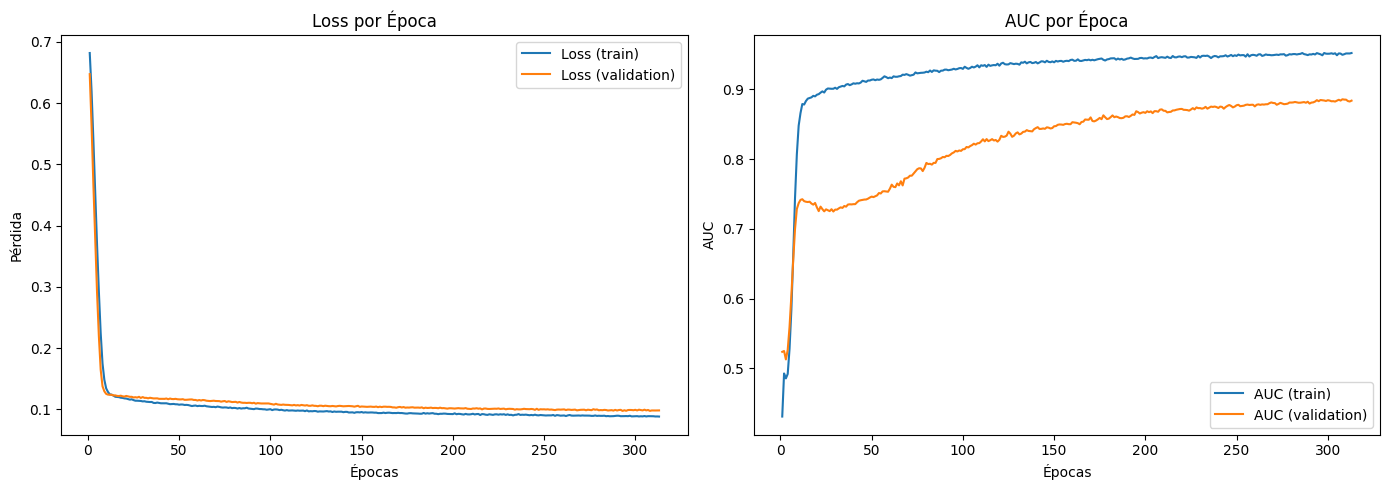

In [ ]:
### Loss and AUC curves plots

def plot_history(history):
    # Retrieving the loss and AUC values
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['AUC']
    val_auc = history.history['val_AUC']

    epochs = range(1, len(loss) + 1)

    # Loss plot
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Loss (train)')
    plt.plot(epochs, val_loss, label='Loss (validation)')
    plt.title('Loss por Época')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # AUC plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, auc, label='AUC (train)')
    plt.plot(epochs, val_auc, label='AUC (validation)')
    plt.title('AUC por Época')
    plt.xlabel('Épocas')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Plotting both curves
plot_history(baseline_history)

.


In [ ]:
### predicting the test set
predictions = model.predict(x_test_modelo)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
### To evaluate model performance per species, we can calculate individual AUCs

aucs = {}
species_names = y_test.columns

for i in range(predictions.shape[1]):
    species_name = species_names[i]
    true_labels = y_test_modelo[:, i]
    pred_probs = predictions[:, i]

    if len(np.unique(true_labels)) > 1:
        auc = roc_auc_score(true_labels, pred_probs)
        aucs[species_name] = auc
    else:
        aucs[species_name] = None

### Checking the results
for species, score in aucs.items():
    if score is not None:
        print(f"AUC para {species}: {score:.4f}")
    else:
        print(f"AUC para {species}: Cannot calculate AUC (only one class present)")

AUC para Acratosaura.mentalis: 0.7787
AUC para Adelophryne.baturitensis: 0.9828
AUC para Adelophryne.maranguapensis: 0.9928
AUC para Ameivula.nigrigula: 0.9571
AUC para Anodorhynchus.leari: 0.9880
AUC para Anopetia.gounellei: 0.7216
AUC para Anotosaura.vanzolinia: 0.9714
AUC para Antilophia.bokermanni: 0.9874
AUC para Augastes.lumachella: 0.9532
AUC para Callicebus.barbarabrownae: 0.9899
AUC para Colobosauroides.cearensis: 0.8451
AUC para Copeoglossum.arajara: 0.6858
AUC para Formicivora.iheringi: 0.8737
AUC para Glaucomastix.cyanura: 0.9169
AUC para Glaucomastix.venetacauda: No se puede calcular AUC (solo una clase presente)
AUC para Hemidactylus.agrius: 0.8793
AUC para Herpsilochmus.sellowi: 0.7353
AUC para Hylopezus.ochroleucus: 0.8723
AUC para Kerodon.rupestris: 0.6546
AUC para Leptodactylus.oreomantis: 0.9543
AUC para Lonchophylla.inexpectata: 0.8257
AUC para Megaxenops.parnaguae: 0.8202
AUC para Mesoclemmys.tuberculata: 0.8132
AUC para Myrmorchilus.strigilatus.strigilatus: 0.7010

# Suitability across the geographic space

In [ ]:
### To project the predicted suitability across the geographic space
  ## (i) We load a dataframe with the centroids of all grid cells and their corresponding bioclimatic variables

occs_varbio = pd.read_csv('/content/drive/MyDrive/dataset/occs_varbio.csv', encoding='latin-1', sep=';')
occs_varbio.head()

,x,y,wc2.1_30s_bio_1,wc2.1_30s_bio_2,wc2.1_30s_bio_3,wc2.1_30s_bio_4,wc2.1_30s_bio_5,wc2.1_30s_bio_6,wc2.1_30s_bio_7,wc2.1_30s_bio_8,...,wc2.1_30s_bio_10,wc2.1_30s_bio_11,wc2.1_30s_bio_12,wc2.1_30s_bio_13,wc2.1_30s_bio_14,wc2.1_30s_bio_15,wc2.1_30s_bio_16,wc2.1_30s_bio_17,wc2.1_30s_bio_18,wc2.1_30s_bio_19
0,-47.9795,-19.9795,22.700001,11.483334,66.763565,177.264557,29.900000,12.7,17.200001,24.083332,...,24.150000,20.066668,1515,289,16,79.491913,774,56,704,79
1,-47.9795,-19.9385,22.095833,11.475000,67.105263,172.408844,29.299999,12.2,17.099998,23.433332,...,23.483334,19.516666,1558,291,20,77.217628,783,63,713,84
2,-47.9795,-19.8975,21.941668,11.466667,67.056526,170.704865,29.200001,12.1,17.100000,23.266666,...,23.316668,19.400000,1569,289,21,76.373978,783,66,710,85
3,-47.9795,-19.8565,21.779167,11.458333,67.401962,169.108063,29.000000,12.0,17.000000,23.083332,...,23.133333,19.250000,1580,288,21,75.402466,782,70,707,87
4,-47.9795,-19.8155,21.650000,11.400001,67.857140,168.576920,28.700001,11.9,16.800001,22.983334,...,23.033333,19.133333,1593,286,21,73.911255,780,76,704,90


In [ ]:
  ## (ii) We create an object containing only the predictors
preditoras_mapa = occs_varbio.drop(['x', 'y'], axis=1)
preditoras_mapa.head()

,wc2.1_30s_bio_1,wc2.1_30s_bio_2,wc2.1_30s_bio_3,wc2.1_30s_bio_4,wc2.1_30s_bio_5,wc2.1_30s_bio_6,wc2.1_30s_bio_7,wc2.1_30s_bio_8,wc2.1_30s_bio_9,wc2.1_30s_bio_10,wc2.1_30s_bio_11,wc2.1_30s_bio_12,wc2.1_30s_bio_13,wc2.1_30s_bio_14,wc2.1_30s_bio_15,wc2.1_30s_bio_16,wc2.1_30s_bio_17,wc2.1_30s_bio_18,wc2.1_30s_bio_19
0,22.700001,11.483334,66.763565,177.264557,29.900000,12.7,17.200001,24.083332,20.316668,24.150000,20.066668,1515,289,16,79.491913,774,56,704,79
1,22.095833,11.475000,67.105263,172.408844,29.299999,12.2,17.099998,23.433332,19.799999,23.483334,19.516666,1558,291,20,77.217628,783,63,713,84
2,21.941668,11.466667,67.056526,170.704865,29.200001,12.1,17.100000,23.266666,19.650000,23.316668,19.400000,1569,289,21,76.373978,783,66,710,85
3,21.779167,11.458333,67.401962,169.108063,29.000000,12.0,17.000000,23.083332,19.533333,23.133333,19.250000,1580,288,21,75.402466,782,70,707,87
4,21.650000,11.400001,67.857140,168.576920,28.700001,11.9,16.800001,22.983334,19.400000,23.033333,19.133333,1593,286,21,73.911255,780,76,704,90


In [ ]:
  ## (iii) standardize the predictor variables
preditoras_mapa_tr = num_pipeline.transform(preditoras_mapa)

In [ ]:
probabilidades_mapa = model.predict(preditoras_mapa_tr)

3437/3437 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [ ]:
### Loading the species names
species_names = y_test.columns.tolist()

probabilidades_df = pd.DataFrame(probabilidades_mapa, columns=species_names)

### Adding the coordinates back
probabilidades_df['x'] = occs_varbio['x']
probabilidades_df['y'] = occs_varbio['y']

In [ ]:
probabilidades_df.head()

,Acratosaura.mentalis,Adelophryne.baturitensis,Adelophryne.maranguapensis,Ameivula.nigrigula,Anodorhynchus.leari,Anopetia.gounellei,Anotosaura.vanzolinia,Antilophia.bokermanni,Augastes.lumachella,Callicebus.barbarabrownae,...,Tropidurus.erythrocephalus,Tropidurus.helenae,Tropidurus.jaguaribanus,Tropidurus.pinima,Tropidurus.semitaeniatus,Vanzosaura.multiscutata,Wiedomys.pyrrhorhinos,Xeronycteris.vieirai,x,y
0,0.002517,1.841068e-08,0.000002,9.569425e-08,2.984725e-08,0.003613,3.629830e-09,3.204098e-08,0.045710,0.000102,...,5.677089e-08,0.000004,0.000001,0.000005,0.012634,0.000061,0.000791,9.390367e-07,-47.9795,-19.9795
1,0.002761,1.799665e-08,0.000003,1.321650e-07,3.195017e-08,0.003976,2.808030e-09,2.238301e-08,0.102955,0.000095,...,7.142576e-08,0.000004,0.000001,0.000008,0.012424,0.000051,0.000766,7.935130e-07,-47.9795,-19.9385
2,0.002791,1.639179e-08,0.000003,1.324078e-07,3.045881e-08,0.003956,2.452779e-09,1.755777e-08,0.124230,0.000091,...,6.985415e-08,0.000004,0.000001,0.000008,0.012341,0.000046,0.000733,7.310534e-07,-47.9795,-19.8975
3,0.002898,1.744365e-08,0.000004,1.479614e-07,3.220789e-08,0.004121,2.462600e-09,1.699202e-08,0.149646,0.000092,...,7.696982e-08,0.000004,0.000001,0.000010,0.012514,0.000046,0.000742,7.353088e-07,-47.9795,-19.8565
4,0.002884,1.608140e-08,0.000004,1.523535e-07,2.817313e-08,0.004090,2.138847e-09,1.277093e-08,0.193116,0.000088,...,7.512145e-08,0.000004,0.000001,0.000011,0.012447,0.000041,0.000702,6.578260e-07,-47.9795,-19.8155


In [ ]:
### Checking data classes in colums
print(probabilidades_df.dtypes)

Acratosaura.mentalis                    float32
Adelophryne.baturitensis                float32
Adelophryne.maranguapensis              float32
Ameivula.nigrigula                      float32
Anodorhynchus.leari                     float32
Anopetia.gounellei                      float32
Anotosaura.vanzolinia                   float32
Antilophia.bokermanni                   float32
Augastes.lumachella                     float32
Callicebus.barbarabrownae               float32
Colobosauroides.cearensis               float32
Copeoglossum.arajara                    float32
Formicivora.iheringi                    float32
Glaucomastix.cyanura                    float32
Glaucomastix.venetacauda                float32
Hemidactylus.agrius                     float32
Herpsilochmus.sellowi                   float32
Hylopezus.ochroleucus                   float32
Kerodon.rupestris                       float32
Leptodactylus.oreomantis                float32
Lonchophylla.inexpectata                

In [ ]:
### saving a csv with suitability
probabilidades_df.to_csv('/caminho/adequabilidade.csv', sep='\t', index=False)